<a href="https://colab.research.google.com/github/ucfilho/Vinicius_Air/blob/main/JUN/models_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import necessary modules, set up the plotting
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
from matplotlib import pyplot as plt
import GPy

# Interacting with models

### November 2014, by Max Zwiessele
#### with edits by James Hensman

The GPy model class has a set of features which are designed to make it simple to explore the parameter space of the model. By default, the scipy optimisers are used to fit GPy models (via model.optimize()), for which we provide mechanisms for ‘free’ optimisation: GPy can ensure that naturally positive parameters (such as variances) remain positive. But these mechanisms are much more powerful than simple reparameterisation, as we shall see.

Along this tutorial we’ll use a sparse GP regression model as example. This example can be in GPy.examples.regression. All of the examples included in GPy return an instance of a model class, and therefore they can be called in the following way:

In [3]:
m = GPy.examples.regression.sparse_GP_regression_1D(plot=False, optimize=False)

## Examining the model using print

To see the current state of the model parameters, and the model’s (marginal) likelihood just print the model

    print m

The first thing displayed on the screen is the log-likelihood value of the model with its current parameters. Below the log-likelihood, a table with all the model’s parameters is shown. For each parameter, the table contains the name of the parameter, the current value, and in case there are defined: constraints, ties and prior distrbutions associated.

In [4]:
m

sparse_gp.,value,constraints,priors
inducing inputs,"(5, 1)",,
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In this case the kernel parameters (`bf.variance`, `bf.lengthscale`) as well as the likelihood noise parameter (`Gaussian_noise.variance`), are constrained to be positive, while the inducing inputs have no constraints associated. Also there are no ties or prior defined.

You can also print all subparts of the model, by printing the subcomponents individually; this will print the details of this particular parameter handle:

In [5]:
m.rbf

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


When you want to get a closer look into multivalue parameters, print them directly:

In [6]:
m.inducing_inputs

index,sparse_gp.inducing_inputs,constraints,priors
[0 0],1.18565421,,
[1 0],-1.36431381,,
[2 0],2.16476437,,
[3 0],1.45965795,,
[4 0],-2.28420844,,


In [7]:
m.inducing_inputs[0] = 1

## Interacting with Parameters:

The preferred way of interacting with parameters is to act on the parameter handle itself. Interacting with parameter handles is simple. The names, printed by print m are accessible interactively and programatically. For example try to set the kernel's `lengthscale` to 0.2 and print the result:

In [8]:
m.rbf.lengthscale = 0.2
print(m)


Name : sparse_gp
Objective : 544.4514650235977
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (5, 1)  |               |        
  rbf.variance             |     1.0  |      +ve      |        
  rbf.lengthscale          |     0.2  |      +ve      |        
  Gaussian_noise.variance  |     1.0  |      +ve      |        


This will already have updated the model’s inner state: note how the log-likelihood has changed. YOu can immediately plot the model or see the changes in the posterior (`m.posterior`) of the model.

## Regular expressions

The model’s parameters can also be accessed through regular expressions, by ‘indexing’ the model with a regular expression, matching the parameter name. Through indexing by regular expression, you can only retrieve leafs of the hierarchy, and you can retrieve the values matched by calling `values()` on the returned object

In [9]:
print(m['.*var'])
#print "variances as a np.array:", m['.*var'].values()
#print "np.array of rbf matches: ", m['.*rbf'].values()

  index  |             sparse_gp.rbf.variance  |  constraints  |  priors
  [0]    |                         1.00000000  |      +ve      |        
  -----  |  sparse_gp.Gaussian_noise.variance  |  -----------  |  ------
  [0]    |                         1.00000000  |      +ve      |        


There is access to setting parameters by regular expression, as well. Here are a few examples of how to set parameters by regular expression. Note that each time the values are set, computations are done internally to compute the log likeliood of the model.

In [10]:
m['.*var'] = 2.
print(m)
m['.*var'] = [2., 3.]
print(m)


Name : sparse_gp
Objective : 668.7511980227071
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (5, 1)  |               |        
  rbf.variance             |     2.0  |      +ve      |        
  rbf.lengthscale          |     0.2  |      +ve      |        
  Gaussian_noise.variance  |     2.0  |      +ve      |        

Name : sparse_gp
Objective : 697.8436948585284
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (5, 1)  |               |        
  rbf.variance             |     2.0  |      +ve      |        
  rbf.lengthscale          |     0.2  |      +ve      |        
  Gaussian_noise.variance  |     3.0  |      +ve      |        


A handy trick for seeing all of the parameters of the model at once is to regular-expression match every variable:

In [11]:
print(m[''])

  index  |          sparse_gp.inducing_inputs  |  constraints  |  priors
  [0 0]  |                         1.00000000  |               |        
  [1 0]  |                        -1.36431381  |               |        
  [2 0]  |                         2.16476437  |               |        
  [3 0]  |                         1.45965795  |               |        
  [4 0]  |                        -2.28420844  |               |        
  -----  |             sparse_gp.rbf.variance  |  -----------  |  ------
  [0]    |                         2.00000000  |      +ve      |        
  -----  |          sparse_gp.rbf.lengthscale  |  -----------  |  ------
  [0]    |                         0.20000000  |      +ve      |        
  -----  |  sparse_gp.Gaussian_noise.variance  |  -----------  |  ------
  [0]    |                         3.00000000  |      +ve      |        


## Setting and fetching parameters parameter_array

Another way to interact with the model’s parameters is through the parameter_array. The Parameter array holds all the parameters of the model in one place and is editable. It can be accessed through indexing the model for example you can set all the parameters through this mechanism:

In [12]:
new_params = np.r_[[-4,-2,0,2,4], [.1,2], [.7]]
print(new_params)

m[:] = new_params
print(m)     

[-4.  -2.   0.   2.   4.   0.1  2.   0.7]

Name : sparse_gp
Objective : 322.84143043388656
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (5, 1)  |               |        
  rbf.variance             |     0.1  |      +ve      |        
  rbf.lengthscale          |     2.0  |      +ve      |        
  Gaussian_noise.variance  |     0.7  |      +ve      |        


Parameters themselves (leafs of the hierarchy) can be indexed and used the same way as numpy arrays. First let us set a slice of the inducing_inputs:

In [13]:
m.inducing_inputs[2:, 0] = [1,3,5]
print(m.inducing_inputs)

  index  |  sparse_gp.inducing_inputs  |  constraints  |  priors
  [0 0]  |                -4.00000000  |               |        
  [1 0]  |                -2.00000000  |               |        
  [2 0]  |                 1.00000000  |               |        
  [3 0]  |                 3.00000000  |               |        
  [4 0]  |                 5.00000000  |               |        


Or you use the parameters as normal numpy arrays for calculations:

In [14]:
precision = 1./m.Gaussian_noise.variance
print(precision)

[1.42857143]


## Getting the model parameter’s gradients

The gradients of a model can shed light on understanding the (possibly hard) optimization process. The gradients of each parameter handle can be accessed through their gradient field.:

In [15]:
print("all gradients of the model:\n", m.gradient)
print("\n gradients of the rbf kernel:\n", m.rbf.gradient)

all gradients of the model:
 [   2.47267196    4.26430046    1.27818184   -0.47043912   -0.39664294
  106.12634945  -13.01553301 -267.95421593]

 gradients of the rbf kernel:
 [106.12634945 -13.01553301]


If we optimize the model, the gradients (should be close to) zero

In [16]:
m.optimize()
print(m.gradient)

[ 1.16443860e-03  2.61056676e-04  1.97465230e-04 -7.85109249e-04
 -2.16804609e-04  8.12960934e-05  1.51292974e-04 -4.79574405e-01]


## Adjusting the model’s constraints

When we initially call the example, it was optimized and hence the log-likelihood gradients were close to zero. However, since we have been changing the parameters, the gradients are far from zero now. Next we are going to show how to optimize the model setting different restrictions on the parameters.

Once a constraint has been set on a parameter, it is possible to remove it with the command unconstrain(), which can be called on any parameter handle of the model. The methods constrain() and unconstrain() return the indices which were actually unconstrained, relative to the parameter handle the method was called on. This is particularly handy for reporting which parameters where reconstrained, when reconstraining a parameter, which was already constrained:

In [17]:
m.rbf.variance.unconstrain()
print(m)


Name : sparse_gp
Objective : -618.0856538648586
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |                  value  |  constraints  |  priors
  inducing_inputs          |                 (5, 1)  |               |        
  rbf.variance             |     1.3578711901178135  |               |        
  rbf.lengthscale          |     2.4976281897284003  |      +ve      |        
  Gaussian_noise.variance  |  0.0023306642537842836  |      +ve      |        


In [18]:
m.unconstrain()
print(m)


Name : sparse_gp
Objective : -618.0856538648586
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |                  value  |  constraints  |  priors
  inducing_inputs          |                 (5, 1)  |               |        
  rbf.variance             |     1.3578711901178135  |               |        
  rbf.lengthscale          |     2.4976281897284003  |               |        
  Gaussian_noise.variance  |  0.0023306642537842836  |               |        


If you want to unconstrain only a specific constraint, you can call the respective method, such as `unconstrain_fixed()` (or `unfix()`) to only unfix fixed parameters:

In [19]:
m.inducing_inputs[0].fix()
m.rbf.constrain_positive()
print(m)
m.unfix()
print(m)


Name : sparse_gp
Objective : -618.0856538648586
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  sparse_gp.               |                  value  |  constraints  |  priors
  inducing_inputs          |                 (5, 1)  |    {fixed}    |        
  rbf.variance             |     1.3578711901178135  |      +ve      |        
  rbf.lengthscale          |     2.4976281897284003  |      +ve      |        
  Gaussian_noise.variance  |  0.0023306642537842836  |               |        

Name : sparse_gp
Objective : -618.0856538648586
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |                  value  |  constraints  |  priors
  inducing_inputs          |                 (5, 1)  |               |        
  rbf.variance             |     1.3578711901178135  |      +ve      |        
  rbf.lengthscale          |     2.4976281897284003  |      +ve      |        
  Gaussian_

## Tying Parameters

Not yet implemented for GPy version 0.8.0


## Optimizing the model

Once we have finished defining the constraints, we can now optimize the model with the function optimize.:

In [20]:
m.Gaussian_noise.constrain_positive()
m.rbf.constrain_positive()
m.optimize()

reconstraining parameters sparse_gp.rbf


By deafult, GPy uses the lbfgsb optimizer.

Some optional parameters may be discussed here.

 * `optimizer`: which optimizer to use, currently there are lbfgsb, fmin_tnc, scg, simplex or any unique identifier uniquely identifying an optimizer.
Thus, you can say m.optimize('bfgs') for using the `lbfgsb` optimizer
 * `messages`: if the optimizer is verbose. Each optimizer has its own way of printing, so do not be confused by differing messages of different optimizers
 * `max_iters`: Maximum number of iterations to take. Some optimizers see iterations as function calls, others as iterations of the algorithm. Please be advised to look into scipy.optimize for more instructions, if the number of iterations matter, so you can give the right parameters to optimize()
 * `gtol`: only for some optimizers. Will determine the convergence criterion, as the tolerance of gradient to finish the optimization.


## Plotting
Many of GPys models have built-in plot functionality. we distringuish between plotting the posterior of the function (`m.plot_f`) and plotting the posterior over predicted data values (`m.plot`). This becomes especially important for non-Gaussian likleihoods. Here we'll plot the sparse GP model we've been working with. for more information of the meaning of the plot, please refer to the accompanying `basic_gp_regression` and `sparse_gp` noteooks.

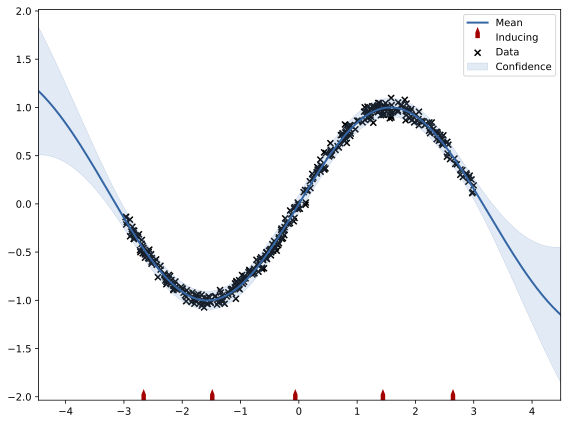

In [21]:
fig = m.plot()

We can even change the backend for plotting and plot the model using a different backend.

In [22]:
GPy.plotting.change_plotting_library('plotly')
#fig = m.plot(plot_density=True)
#fig = m.plot()
#GPy.plotting.show(fig, filename='gpy_sparse_gp_example')

 /usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

